In [1]:
import os
os.chdir('/cluster/home/yushun/scmodel/CellPatch')

In [2]:
import argparse
import torch
import time
import os
import numpy as np

from torch.optim import Adam,SGD,AdamW,lr_scheduler,RAdam
import torch.nn as nn
import torch.nn.functional as F
from Model import Model_lite as Model
from utils import *
from utils.transfer_tools import load_basic_ckpt
from sklearn.metrics import f1_score as cal_f1

torch.autograd.set_detect_anomaly(True)


In [3]:
from utils.tune_tools import read_args_from_json,get_data_from_list,get_model

In [4]:
args = argparse.Namespace(
    project_name = 'demo',
    ckpt_path = '/cluster/home/yushun/scmodel/CellPatch/data/CellPatch_50ep.pth',
    ckpt_config = '/cluster/home/yushun/scmodel/CellPatch/data/CellPatch_50ep_args.json',
    gene2id_dict = '/cluster/home/yushun/scmodel/CellPatch/data/gene2tok.json',

    #hyperparameters
    epoch =100,
    batch_size = 256,
    lr = 1e-3,
    weight_decay = 5e-4,
    log_transform = False,
    balance = False,
    clip = 5,
    long = True,
    dropout = 0.,

    #settings
    device = 'cuda',
    save_dir = './models',
    seed = 0,
    print_every = 100,
    save_each_iters = 1e9,
    project_out = False,
    device_num = [0]
)

#save args to json
import json
with open('./runs/cache/default_config.json', 'w') as f:
    json.dump(vars(args), f, indent=2)

args.ROOT = os.getcwd()
logfile = init_project(args)
model_args = load_config(args.ckpt_config)
default_args = read_args_from_json(args.ckpt_config)

{'config_path': None, 'project_name': '10Mpretrain_lite_10M_0118', 'ckpt_path': '/cluster/home/yushun/scmodel/a_PathFormer/runs/train/10Mpretrain_lite_10M_0108/ckpt/10Mpretrain_lite_10M_0108_ep10_iter_.pth', 'load_optimizer': True, 'epoch': 100, 'save_each_iters': 50000000, 'print_every': 100, 'gene2id_json_path': None, 'data_path': '/cluster/home/yushun/datasample/10M/', 'batch_size': 512, 'mask_rate': 0.3, 'log_transform': True, 'device': 'cuda:0', 'device_num': [0, 1], 'max_gene_num': 70000, 'embedding_dim': 32, 'max_trainning_length': 3000, 'max_decode_length': 1000, 'n_pathway': 64, 'n_head': 2, 'encoder_cross_attn_depth': 1, 'encoder_self_attn_depth': 2, 'encoder_projection_dim': 10, 'decoder_extract_block_depth': 1, 'decoder_selfattn_block_depth': 1, 'decoder_projection_dim': 1, 'optimizer': 'adam', 'learnning_rate': 0.0001, 'weight_decay': 5e-05, 'ROOT': '/cluster/home/yushun/scmodel/a_PathFormer', 'ROOT_DIR': '/cluster/home/yushun/scmodel/a_PathFormer/runs/train/', 'PROJECT_DI

In [5]:
#load dataset & update gene2id_dict
args.data_path = '/cluster/home/yushun/scmodel/CellPatch/data/scbert_preprocessed_data.h5ad'

if os.path.isdir(args.data_path):
    data_path = [os.path.join(args.data_path,_) for _ in os.listdir(args.data_path) if _.endswith('h5ad')]
else:
    data_path = [args.data_path]  
      
trainloader,valloader,testloader,gene2id_dict,args.num_class,cell_type_dict = get_tune_dataloader(
        data_path=data_path,
        gene2tok_dict=load_gene2id(args.gene2id_dict),
        batch_size=args.batch_size,
        shuffle = True,
        num_workers=8,
        log_transform = args.log_transform,
        balanced = args.balance,
        clip = args.clip,
        long = args.long,
        seed = args.seed
    )

loss_fn = nn.CrossEntropyLoss()

train size: 54760
val size: 6845
test size: 6845


In [ ]:
testloader

In [6]:
model = Model.PathFormer_lp(
            max_gene_num=default_args.max_gene_num,
            embedding_dim=default_args.embedding_dim,
            max_trainning_length = default_args.max_trainning_length,
            n_pathway = default_args.n_pathway,
            n_head = default_args.n_head,
            mlp_dim = None,
            encoder_cross_attn_depth = default_args.encoder_cross_attn_depth,
            encoder_self_attn_depth = default_args.encoder_self_attn_depth,
            encoder_projection_dim = default_args.encoder_projection_dim,
            decoder_extract_block_depth = 1,
            decoder_selfattn_block_depth = 1,
            decoder_projection_dim = 1,
            n_cell_type = args.num_class,
            dropout = args.dropout,
            project_out = args.project_out
            )

init weight


In [7]:
optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = None

ckpt = torch.load(args.ckpt_path,map_location=args.device)
new_state_dict = {}
for k, v in ckpt['model_state_dict'].items():
    if k.startswith('module.'):
        k = k[7:]
    if 'decoder' not in k:
        new_state_dict[k] = v

model.load_state_dict(new_state_dict,strict = False)

for name, param in model.named_parameters():
    param.requires_grad = True

In [8]:
if args.device!='cpu':
    if len(args.device_num) > 1:
        model = torch.nn.DataParallel(model.to(args.device), device_ids=args.device_num)
    else:
        model = model.to(args.device)

In [ ]:
from finetune import train_one_epoch,eval_one_epoch

args.val_min_loss = 1e9
args.val_max_acc = 0
args.test_min_loss = 1e9
args.test_max_acc = 0

for epoch in range(0,args.epoch):
    train_one_epoch(args,model,optimizer,scheduler,loss_fn,trainloader,epoch,logfile,grad_log=None)
    test_acc = eval_one_epoch(args,model,loss_fn,valloader,epoch,logfile,testloader=testloader)

Epoch: [0][ 99/213]	Time  0.484 ( 0.475)	Data 47.522 (25.173)	loss 9.4273e-01 (8.8320e-01)	accuracy 6.4453e-01 (6.6867e-01)	lr 1.0000e-03 (1.0000e-03)
Epoch: [0][199/213]	Time  0.380 ( 0.465)	Data 93.074 (47.869)	loss 7.7201e-01 (8.4732e-01)	accuracy 7.1875e-01 (6.7896e-01)	lr 1.0000e-03 (1.0000e-03)
Epoch: [0][212/213]	Time  0.407 ( 0.464)	Data 98.916 (50.816)	loss 7.2798e-01 (8.4059e-01)	accuracy 7.1875e-01 (6.8139e-01)	lr 1.0000e-03 (1.0000e-03)
Epoch: [0][25/26]	Time  0.020 ( 0.140)	Data  3.652 ( 3.050)	loss 7.3681e-01 (7.6755e-01)	accuracy 7.0703e-01 (7.0328e-01)
Epoch: [0][26/27]	Time  0.006 ( 0.133)	Data  3.582 ( 3.013)	loss 8.0513e-01 (7.7425e-01)	accuracy 6.9312e-01 (7.1045e-01)
Epoch: [1][ 99/213]	Time  0.449 ( 0.487)	Data 48.666 (25.380)	loss 6.5169e-01 (7.2271e-01)	accuracy 7.8125e-01 (7.3223e-01)	lr 1.0000e-03 (1.0000e-03)
Epoch: [1][199/213]	Time  0.535 ( 0.488)	Data 97.582 (49.049)	loss 6.6018e-01 (7.0287e-01)	accuracy 7.7344e-01 (7.3906e-01)	lr 1.0000e-03 (1.0000e-03)
E

Exception ignored in: <function _releaseLock at 0x7fcfe344a4c0>
Traceback (most recent call last):
  File "/cluster/home/hanwen/miniconda3/envs/scmodel/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 401183, 401247, 401310) exited unexpectedly

In [ ]:
# torch.save(model.state_dict(),'./runs/cache/cache_best.pth')

In [9]:
ckpt = torch.load('./runs/cache/cache_best.pth')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [10]:
true_labels = []
pred_labels = []

if args.project_out:
    output_mid = torch.zeros(testloader.dataset.__len__(),model_args.n_pathway,model_args.encoder_projection_dim)
else:
    output_mid = torch.zeros(testloader.dataset.__len__(),model_args.n_pathway,model_args.embedding_dim)

with torch.no_grad():
    model.eval()
    for idx,d in enumerate(testloader):
        count,gene,label = d
        count,gene,label = count.to(args.device),gene.to(args.device),label.to(args.device)
        mid = model.get_mid_embeding(count,gene,project_out=args.project_out)
        pred = model.get_logits(mid,project_out=args.project_out)
        # pred = model(count,gene)
        pred_labels.append(pred.argmax(1).cpu().numpy())
        true_labels.append(label.cpu().numpy())
        output_mid[idx*args.batch_size:(idx+1)*args.batch_size] = mid.cpu()
        
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

acc = np.mean(true_labels == pred_labels)
f1 = cal_f1(true_labels,pred_labels,average='macro')
print(f"Final acc: {acc}, f1: {f1}")

Final acc: 0.8693937180423666, f1: 0.7729606233735601


In [47]:
import scanpy as sc
raw_adata = sc.read_h5ad('/cluster/home/yushun/scmodel/CellPatch/data/scbert_preprocessed_data.h5ad')
shuffle_index = torch.randperm(raw_adata.shape[0])
train_index = shuffle_index[:int(raw_adata.shape[0]*0.7)]
val_index = shuffle_index[int(raw_adata.shape[0]*0.7):int(raw_adata.shape[0]*0.9)]
test_index = shuffle_index[int(raw_adata.shape[0]*0.9):]

adata_train = raw_adata[train_index.numpy()]
adata_val = raw_adata[val_index.numpy()]
adata_test = raw_adata[test_index.numpy()]

if args.project_out:
    new_adata = sc.AnnData(output_mid.numpy().reshape(-1,model_args.n_pathway*model_args.encoder_projection_dim))
else:
    new_adata = sc.AnnData(output_mid.numpy().reshape(-1,model_args.n_pathway*model_args.embedding_dim))

sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)

adata_test.obs['pred'] = pred_labels
#change id to cell type
cell_type_dict_reverse = {v:k for k,v in cell_type_dict.items()}
adata_test.obs['pred'] = adata_test.obs['pred'].map(cell_type_dict_reverse)
adata_test.obs['correct'] = adata_test.obs['pred'] == adata_test.obs['celltype']
adata_test.obs['correct'] = adata_test.obs['correct'].astype(int)

0
         Falling back to preprocessing with `sc.pp.pca` and default params.


/cluster/home/hanwen/miniconda3/envs/scmodel/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/cluster/home/hanwen/miniconda3/envs/scmodel/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cluster/home/hanwen/miniconda3/envs/scmodel/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/home/hanwen/miniconda3/envs/scmodel/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vec

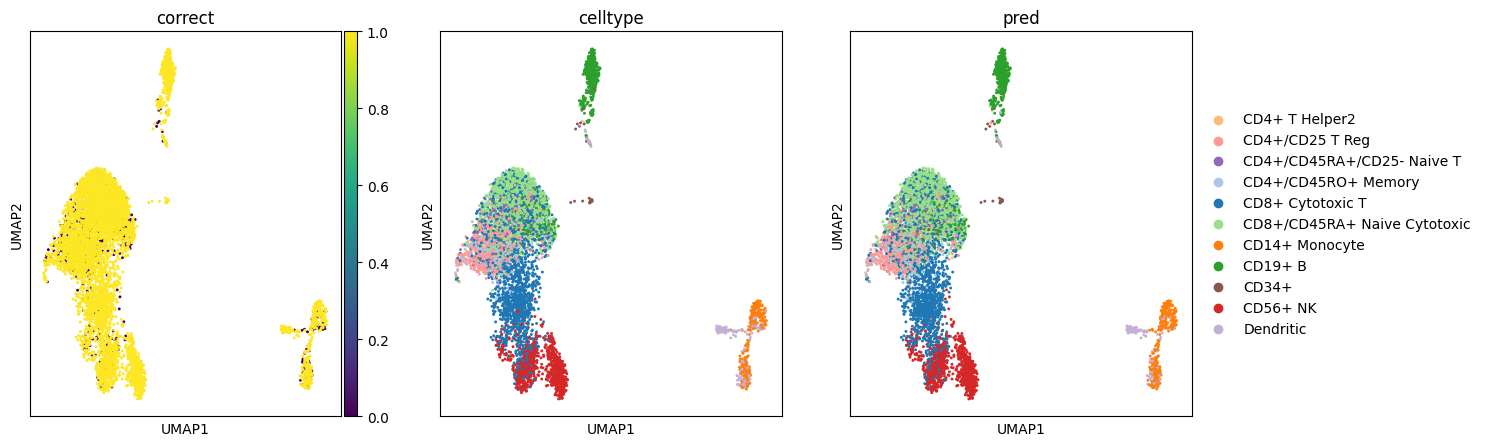

In [12]:
import matplotlib.pyplot as plt
# umap showing true and pred

celltype = adata_test.obs['celltype'].unique()
color_map = dict(zip(celltype,plt.cm.tab20.colors[:len(celltype)]))
fig,ax = plt.subplots(1,3,figsize=(15,5))
sc.pl.umap(adata_test,color='correct',ax=ax[0],show=False)
sc.pl.umap(adata_test,color='celltype',ax=ax[1],show=False,palette=color_map,legend_loc=None)
sc.pl.umap(adata_test,color='pred',ax=ax[2],show=False,palette=color_map)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(50.7222222222222, 0.5, 'true_labels')

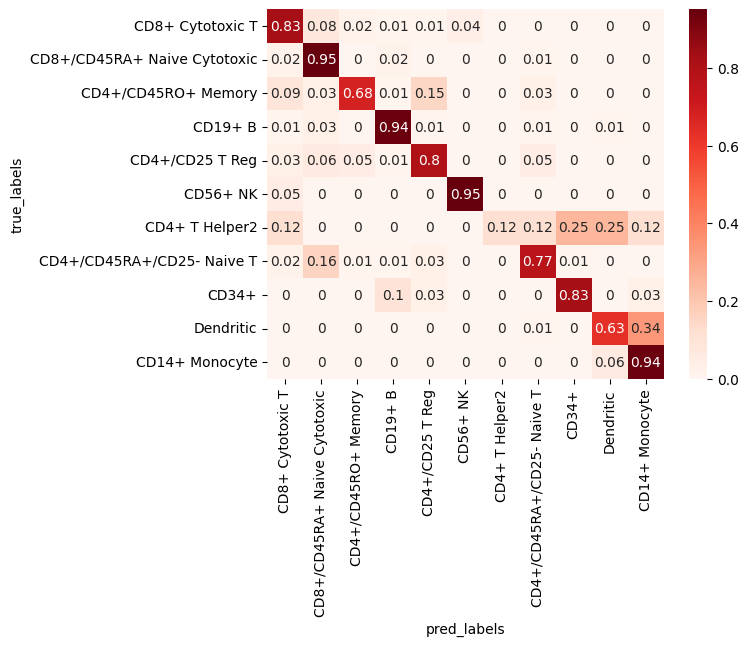

In [70]:
C = confusion_matrix(true_labels,pred_labels,normalize='true')
C = np.round(C,2)
sns.heatmap(C,annot = True,cmap = 'Reds',xticklabels=cell_type_dict.keys(),yticklabels=cell_type_dict.keys())
plt.xlabel('pred_labels')
plt.ylabel('true_labels')